In [2]:
## Imports ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import (LeaveOneOut, RandomizedSearchCV,
                                     RepeatedKFold, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler

In [3]:
## Read in Data ## 
df_orig = pd.read_csv('../data/processed/CPA-virtual_database.csv')
df = df_orig[df_orig['Rxn_Type'] == 'Training']

y, x = df.loc[:, 'ddG'],df.loc[:, df.columns[9:]]

In [4]:
## Train-test split ##
 
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=25)

In [5]:
## Normalise Data ##
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [6]:
## Hyperparameter Tuning ##

n_estimators = range(1,200)
max_depth = range(1,200)
min_samples_split = range(1,10)
min_samples_leaf = range(1,10)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

In [ ]:
regressor = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, cv=10, n_iter=500,scoring='r2', random_state=25)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
hp_tune_1 = pd.DataFrame(rf_random.cv_results_)

In [28]:
## Hyperparameter Tuning 2 ##

n_estimators = range(20,250)
max_depth = range(60,200)
min_samples_split = range(2,9)
min_samples_leaf = range(1,2)

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

In [29]:
regressor = RandomForestRegressor(bootstrap=True)

rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, cv=10, n_iter=500,scoring='r2', random_state=25)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
hp_tune_2 = pd.DataFrame(rf_random.cv_results_)

{'n_estimators': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 72}


In [5]:
## Train Model ##

regressor_tuned = RandomForestRegressor(n_estimators=28, min_samples_split=2, min_samples_leaf=1, max_depth=72, bootstrap=True)
model = regressor_tuned.fit(X_train, y_train)
train_predict = model.predict(X_train)

Train MAE = 0.16198729358732172
Train R^2 = 0.9768141917306066


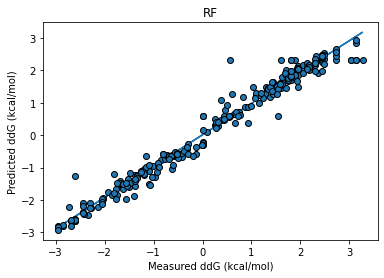

In [6]:
## Plot Training Model ##

plt.scatter(y_train,train_predict, edgecolor='black')
print('Train MAE = ' + str(mae(y_train,train_predict)))
print('Train R^2 = ' + str(r2_score(y_train,train_predict)))
plt.xlabel('Measured ddG (kcal/mol)')
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('RF')
m, b = np.polyfit(y_train, train_predict, 1)
plt.plot(y_train,m*y_train+b, zorder = 0)

In [17]:
# K-fold Cross validation score
from sklearn.model_selection import cross_val_predict


rep_cv = RepeatedKFold(n_splits=10,n_repeats=10)
cv_model = cross_validate(
    regressor_tuned,
    X_train,
    y_train,
    cv = rep_cv,
    scoring=('r2','neg_mean_absolute_error')
)
cv_r2 = (np.average(cv_model['test_r2']))

#LOO
loo = LeaveOneOut()
loo_model = cross_val_predict(
    regressor_tuned,
    X_train,
    y_train,
    cv = loo,
)
loo_r2 = r2_score(y_train,loo_model)  


In [7]:
## Predict X Test ##

X_test_ = scaler.transform(X_test)
test_predict = model.predict(X_test_)

Test MAE = 0.2578538947207072
Test R^2 = 0.9618770174398479


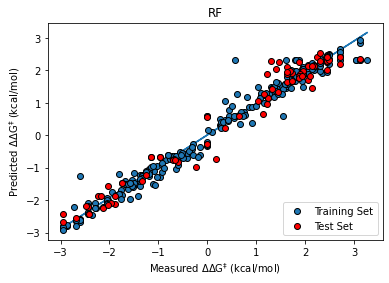

In [8]:
## Plot Test Model ##

plt.plot(y_train,m*y_train+b, zorder = 0)

plt.scatter(y_train,train_predict, edgecolor = 'black', zorder = 15, label = 'Training Set')

plt.scatter(y_test,test_predict, facecolor='red', edgecolor = 'black', zorder = 20, label = 'Test Set')

plt.title('RF')
plt.xlabel('Measured $\Delta\Delta$G$^‡$ (kcal/mol)')
plt.ylabel('Predicted $\Delta\Delta$G$^‡$ (kcal/mol)')
plt.legend(loc="lower right")
print('Test MAE = ' + str(mae(y_test,test_predict)))
print('Test R^2 = ' + str(r2_score(y_test,test_predict)))